In [1]:
import numpy as np
import matplotlib.pyplot as plt

from braket.ahs.atom_arrangement import AtomArrangement

from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from utils import show_register, show_global_drive, show_final_avg_density, get_drive, get_avg_density

from braket.devices import LocalSimulator

In [2]:
import numpy as np

amplitude_min = 0
amplitude_max = 6.3e6  # rad / s
detuning_min = -6e6  # rad / s
detuning_max = 15e6  # rad / s
time_max = 4e-6  # s
time_ramp = 5e-7  # s
time_to_measure = 1e-7 # s

times = np.linspace(2e-7,time_max - 2e-7,11)

full_time_points = [0, time_ramp, time_max - time_ramp, time_max]
full_amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]
full_detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
fill_phase_values = [0, 0, 0, 0]


drive_list = []
for time in times:
    amplitude_end = np.interp(time,full_time_points,full_amplitude_values)
    detuning_end = np.interp(time,full_time_points,full_detuning_values)
    indx = np.searchsorted(full_time_points,time)
    
    time_points = full_time_points[:indx] + [time,time+time_to_measure]
    amplitude_values = full_amplitude_values[:indx] + [amplitude_end,0.0]
    detuning_values = full_detuning_values[:indx] + [detuning_end,detuning_end]
    phase_values = fill_phase_values[:indx] + [0,0]
    
    
    drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)
    drive_list.append(drive)

drive = get_drive(full_time_points, full_amplitude_values, full_detuning_values, fill_phase_values)

drive_list.append(drive)
times = list(times) + [time_max]


print(len(drive_list),len(times))



12 12


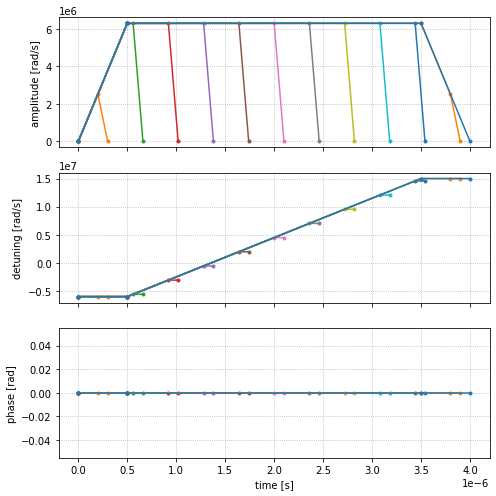

In [3]:
axes = show_global_drive(drive_list[-1],zorder=10)


for drive in drive_list[:-1]:
    show_global_drive(drive,axes=axes)



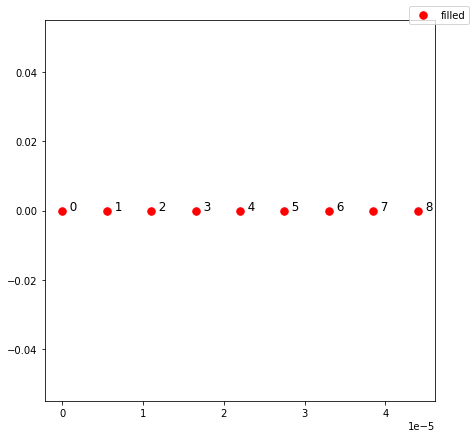

In [4]:
register = AtomArrangement()
separation = 5.5e-6  # in meters 
num_atoms = 9

for k in range(num_atoms):
    register.add([k * separation, 0])
    
show_register(register)

In [5]:
avg_densities_chain = np.zeros((len(drive_list),len(register)))

chain_results = []
device = LocalSimulator("braket_ahs")

for i,drive in enumerate(drive_list):
    ahs_program = AnalogHamiltonianSimulation(
        register=register, 
        hamiltonian=drive
    )
#     ahs_program.discretize(device)
    result = device.run(ahs_program, shots=1000).result()
    chain_results.append(result)
    
    avg_densities_chain[i,:] = get_avg_density(result)



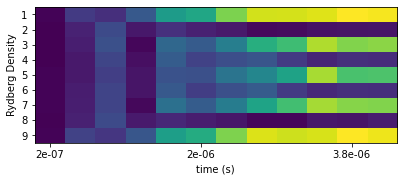

In [6]:
f,ax = plt.subplots(1,1,figsize=(10,2.5))

ax.imshow(avg_densities_chain.T)
ax.set_xticks(ticks = np.arange(0,len(times),5), labels=np.around(times[::5],14))
ax.set_yticks(ticks = np.arange(0,len(register)),labels=range(1,len(register)+1))
ax.set_aspect(0.5)
ax.set_xlabel("time (s)")
ax.set_ylabel("Rydberg Density")
plt.show()

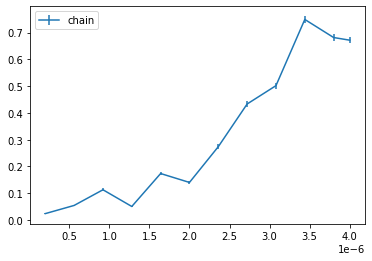

In [8]:
order_parameter_chain = []

sign = (-1)**np.arange(len(register)) # get signs for each site

for i,chain_result in enumerate(chain_results):
    postSeqs_chain = np.array([measurement.post_sequence for measurement in chain_result.measurements])
    shots_order_param_chain = np.square(np.sum(sign * ( 2 * postSeqs_chain - 1),axis=1)/len(register))
    mean = np.mean(shots_order_param_chain)
    std_err = np.std(shots_order_param_chain)/np.sqrt(len(shots_order_param_chain))
    order_parameter_chain.append((mean,std_err))
    
    
mean,err = list(zip(*order_parameter_chain))

plt.errorbar(times,mean,err,label="chain",marker="")
plt.legend()
plt.show()